<a href="https://colab.research.google.com/github/abahrii/test/blob/main/POLIST_02_notebookclustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook du modèle
Réalisé par : BAHRI Abdelghani

## 1. l'importation des outils / bibliothéques et de la base de données déja nettoyée

In [ ]:
import pandas as pd
import numpy as np
%pylab inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
from lifetimes.utils import *
from sklearn import preprocessing, metrics, cluster, decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.metrics import silhouette_samples, silhouette_score, adjusted_mutual_info_score
from sklearn.decomposition import PCA


Populating the interactive namespace from numpy and matplotlib


In [ ]:
data=pd.read_csv("cleaned_data_tr.csv")


In [ ]:
data.head()

,Unnamed: 0,customer_unique_id_x,shipping_limit_date,order_purchase_timestamp,price,order_approved_at,product_id,order_status,order_id,order_estimated_delivery_date,freight_value,order_delivered_carrier_date,seller_id,order_delivered_customer_date,order_item_id,customer_unique_id_y,customer_id,customer_unique_id
0,0,7c396fd4830fd04220f754e42b4e5bff,2017-10-06 11:07:15,2017-10-02 10:56:33,29.99,2017-10-02 11:07:15,87285b34884572647811a353c7ac498a,delivered,e481f51cbdc54678b7cc49136f2d6af7,2017-10-18 00:00:00,8.72,2017-10-04 19:55:00,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-10 21:25:13,1,7c396fd4830fd04220f754e42b4e5bff,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff
1,1,af07308b275d755c9edb36a90c618231,2018-07-30 03:24:27,2018-07-24 20:41:37,118.70,2018-07-26 03:24:27,595fac2a385ac33a80bd5114aec74eb8,delivered,53cdb2fc8bc7dce0b6741e2150273451,2018-08-13 00:00:00,22.76,2018-07-26 14:31:00,289cdb325fb7e7f891c38608bf9e0962,2018-08-07 15:27:45,1,af07308b275d755c9edb36a90c618231,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231
2,2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-13 08:55:23,2018-08-08 08:38:49,159.90,2018-08-08 08:55:23,aa4383b373c6aca5d8797843e5594415,delivered,47770eb9100c2d0c44946d9cf07ec65d,2018-09-04 00:00:00,19.22,2018-08-08 13:50:00,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-17 18:06:29,1,3a653a41f6f9fc3d2a113cf8398680e8,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8
3,3,7c142cf63193a1473d2e66489a9ae977,2017-11-23 19:45:59,2017-11-18 19:28:06,45.00,2017-11-18 19:45:59,d0b61bfb1de832b15ba9d266ca96e5b0,delivered,949d5b44dbf5de918fe9c16f97b45f8a,2017-12-15 00:00:00,27.20,2017-11-22 13:39:59,66922902710d126a0e7d26b0e3805106,2017-12-02 00:28:42,1,7c142cf63193a1473d2e66489a9ae977,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977
4,4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-19 20:31:37,2018-02-13 21:18:39,19.90,2018-02-13 22:20:29,65266b2da20d04dbe00c5c2d3bb7859e,delivered,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-26 00:00:00,8.72,2018-02-14 19:46:34,2c9e548be18521d1c43cde1c582c6de8,2018-02-16 18:17:02,1,72632f0f9dd73dfee390c9b22eb56dd6,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6


In [ ]:
transaction_data = data[['customer_unique_id','order_purchase_timestamp','price']]
## convert timestamp to date; only need the day
transaction_data['date'] = pd.to_datetime(transaction_data['order_purchase_timestamp']).dt.date
transaction_data = transaction_data.drop('order_purchase_timestamp',axis=1)
transaction_data.head()

,customer_unique_id,price,date
0,7c396fd4830fd04220f754e42b4e5bff,29.99,2017-10-02
1,af07308b275d755c9edb36a90c618231,118.70,2018-07-24
2,3a653a41f6f9fc3d2a113cf8398680e8,159.90,2018-08-08
3,7c142cf63193a1473d2e66489a9ae977,45.00,2017-11-18
4,72632f0f9dd73dfee390c9b22eb56dd6,19.90,2018-02-13



Maintenant que j'ai mes données de transaction, je veux les convertir en dataframe avec les variables RFM. Le package Lifetimes a une fonction pour convertir les données de transaction en RFM DataFrame.

In [ ]:
data_tr = summary_data_from_transaction_data(transaction_data,'customer_unique_id','date',monetary_value_col='price')
data_tr.describe()

,frequency,recency,T,monetary_value
count,95420.000000,95420.000000,95420.000000,95420.000000
mean,0.024198,2.683389,246.184846,2.474897
std,0.178936,25.263074,153.656402,26.579606
min,0.000000,0.000000,5.000000,0.000000
25%,0.000000,0.000000,122.000000,0.000000
50%,0.000000,0.000000,227.000000,0.000000
75%,0.000000,0.000000,356.000000,0.000000
max,15.000000,633.000000,729.000000,1999.990000


In [ ]:
data_tr.head()

,frequency,recency,T,monetary_value
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,116.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,119.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,542.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,326.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,293.0,0.0



La fonction data_tr convertit les transactions des clients en un tableau agrégé. De nombreux clients ont une fréquence, une récence et une valeur monétaire = 0, comme le client 0000366f3b9a7992bf8c76cfdf3221e2. En effet, Lifetimes ne prend en compte que les clients ayant effectué des achats répétés.


les variables sont définies ainsi pour le modèle Lifetimes:
    
    - Frequency: nombre d'achats répétés effectués par un client (achats totaux - 1)
    - Recency : délai entre l'achat initial et le dernier achat
    - Monetary_value: total dépensé pour les achats
    - T : âge du client en jours



In [ ]:
data=data_tr[data_tr['frequency']>0]
data.head()

,frequency,recency,T,monetary_value
customer_unique_id,,,,
004288347e5e88a27ded2bb23747066c,1.0,171.0,403.0,87.90
004b45ec5c64187465168251cd1c9c2f,1.0,267.0,367.0,27.00
0058f300f57d7b93c477a131a59b36c3,1.0,31.0,196.0,72.58
00a39521eb40f7012db50455bf083460,1.0,11.0,103.0,11.55
011575986092c30523ecb71ff10cb473,1.0,60.0,198.0,63.90


Les fréquences qui sont répétés par rapport au valeurs monétaires

In [ ]:
data_FR= data_tr.groupby(['frequency'])['monetary_value'].count().sort_values(ascending=False)
data_FR.head(100)

frequency
0.0     93335
1.0      1927
2.0       126
3.0        18
4.0         6
5.0         5
6.0         2
15.0        1
Name: monetary_value, dtype: int64

### Dataframe avec 2 features

In [ ]:
data_RF= data[[ 'frequency','monetary_value' ]]
data_RF.head(100)

,frequency,monetary_value
customer_unique_id,,
004288347e5e88a27ded2bb23747066c,1.0,87.900
004b45ec5c64187465168251cd1c9c2f,1.0,27.000
0058f300f57d7b93c477a131a59b36c3,1.0,72.580
00a39521eb40f7012db50455bf083460,1.0,11.550
011575986092c30523ecb71ff10cb473,1.0,63.900
011b4adcd54683b480c4d841250a987f,1.0,56.970
012452d40dafae4df401bced74cdb490,1.0,330.000
012a218df8995d3ec3bb221828360c86,1.0,1369.900
013ef03e0f3f408dd9bf555e4edcdc0a,1.0,59.900


### Data prepocessing

In [ ]:
X= data_RF
X.shape


(2085, 2)

In [ ]:
scaler = StandardScaler()
scaler.fit(X)
X_data = scaler.transform(X)
X_data.shape

(2085, 2)

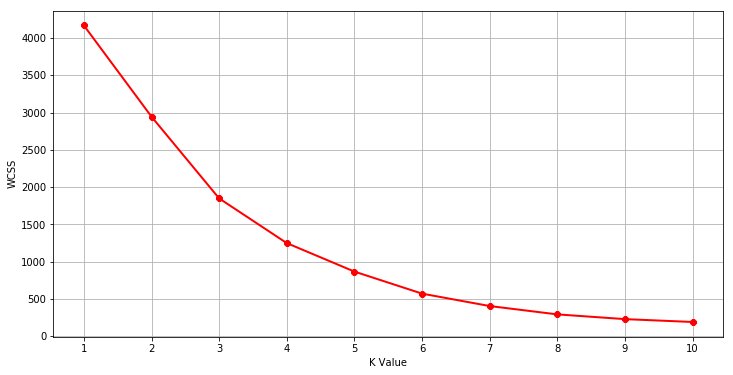

In [ ]:
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X_data)
    wcss.append(km.inertia_)
plt.figure(figsize=(12,6))
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

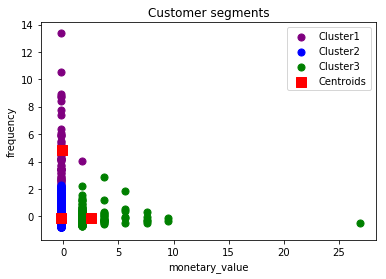

In [ ]:
##Fitting kmeans to the dataset with k=4
km4=KMeans(n_clusters=3,init='k-means++', max_iter=300, n_init=10, random_state=0)
y_means = km4.fit_predict(X_data)
#Visualizing the clusters for k=4
plt.scatter(X_data[y_means==0,0],X_data[y_means==0,1],s=50, c='purple',label='Cluster1')
plt.scatter(X_data[y_means==1,0],X_data[y_means==1,1],s=50, c='blue',label='Cluster2')
plt.scatter(X_data[y_means==2,0],X_data[y_means==2,1],s=50, c='green',label='Cluster3')
#plt.scatter(X_data[y_means==3,0],X_data[y_means==3,1],s=50, c='cyan',label='Cluster4')
#plt.scatter(X_data[y_means==4,0],X_data[y_means==4,1],s=50, c='magenta',label='Cluster5')
#plt.scatter(X_data[y_means==5,0],X_data[y_means==5,1],s=50, c='orange',label='Cluster6')
plt.scatter(km4.cluster_centers_[:,0], km4.cluster_centers_[:,1],s=100,marker='s', c='red', alpha=1, label='Centroids')
plt.title('Customer segments')
plt.xlabel('monetary_value')
plt.ylabel('frequency')
plt.legend()
plt.show()

In [ ]:
data_RF["Cluster"]=y_means

In [ ]:
data_RF=data_RF.groupby(['Cluster']).agg({
    'frequency': 'mean',
    'monetary_value': ['mean','count'],
}).round(0)


In [ ]:
data_RF.head()

frequency monetary_value      
             mean           mean count
Cluster                               
0             1.0          792.0    51
1             1.0           96.0  1877
2             2.0          101.0   157

K-means avec 2 features et avec 2 clusters

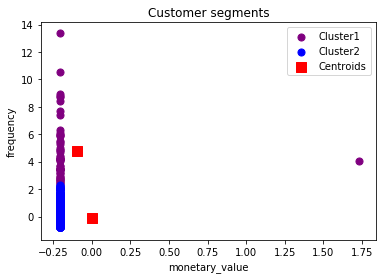

In [ ]:
km4=KMeans(n_clusters=2,init='k-means++', max_iter=300, n_init=10, random_state=0)
y_means2 = km4.fit_predict(X_data)
#Visualizing the clusters for k=4
plt.scatter(X_data[y_means==0,0],X_data[y_means==0,1],s=50, c='purple',label='Cluster1')
plt.scatter(X_data[y_means==1,0],X_data[y_means==1,1],s=50, c='blue',label='Cluster2')

plt.scatter(km4.cluster_centers_[:,0], km4.cluster_centers_[:,1],s=100,marker='s', c='red', alpha=1, label='Centroids')
plt.title('Customer segments')
plt.xlabel('monetary_value')
plt.ylabel('frequency')
plt.legend()
plt.show()

In [ ]:
data_RF["Cluster"]=y_means2

In [ ]:
data_RF=data_RF.groupby(['Cluster']).agg({
    'frequency': 'mean',
    'monetary_value': ['mean','count'],
}).round(0)

In [ ]:
data_RF.head()

frequency monetary_value      
             mean           mean count
Cluster                               
0             1.0           96.0  2033
1             1.0          787.0    52

### Dataframe avec 3 features

In [ ]:
data_RFM= data[[ 'recency' ,'frequency', 'monetary_value']]
data_RFM.head()

,recency,frequency,monetary_value
customer_unique_id,,,
004288347e5e88a27ded2bb23747066c,171.0,1.0,87.90
004b45ec5c64187465168251cd1c9c2f,267.0,1.0,27.00
0058f300f57d7b93c477a131a59b36c3,31.0,1.0,72.58
00a39521eb40f7012db50455bf083460,11.0,1.0,11.55
011575986092c30523ecb71ff10cb473,60.0,1.0,63.90


In [ ]:
X= data_RFM
X.shape

(2085, 3)

In [ ]:
scaler = StandardScaler()
scaler.fit(X)
X_data = scaler.transform(X)
X_data.shape

(2085, 3)

In [ ]:
pca= decomposition.PCA(n_components=2)
pca.fit(X_data)
print(pca.explained_variance_ratio_.cumsum())
X_trans= pca.transform(X_data)

[0.40047122 0.73296095]


### 1- K-means

In [ ]:
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X_data)
    wcss.append(km.inertia_)
plt.figure(figsize=(12,6))
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

NameError: ignored

In [ ]:
k_means=KMeans(n_clusters=4,init='k-means++', max_iter=300, n_init=10, random_state=0)
t0 = time.time()
y_means = k_means.fit_predict(X_data)
t_batch = time.time() - t0
print('train time: %.2fs\ninertia: %f' % (t_batch, k_means.inertia_))

fig = plt.figure( figsize=(20, 10))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(X_data[y_means==0,0],X_data[y_means==0,1],X_data[y_means==0,2],s=50, c='purple',label='Cluster1')
ax.scatter(X_data[y_means==1,0],X_data[y_means==1,1],X_data[y_means==1,2],s=50, c='blue',label='Cluster2')
ax.scatter(X_data[y_means==2,0],X_data[y_means==2,1],X_data[y_means==2,2],s=50, c='green',label='Cluster3')
ax.scatter(X_data[y_means==3,0],X_data[y_means==3,1],X_data[y_means==3,2],s=50, c='cyan',label='Cluster4')
#ax.scatter(X_data[y_means==4,0],X_data[y_means==4,1],X_data[y_means==4,2],s=50, c='magenta',label='Cluster5')
#plt.scatter(X_data[y_means==5,0],X_data[y_means==5,1],s=50, c='orange',label='Cluster6')
ax.scatter(k_means.cluster_centers_[:,0], k_means.cluster_centers_[:,1], k_means.cluster_centers_[:,2],s=200,marker='s', c='red', alpha=0.7, label='Centroids')
ax.set_title('KMeans')
ax.set_xlabel('frequency')
ax.set_ylabel('monetary_value')
ax.set_zlabel('recency')
ax.dist = 9
plt.legend()
plt.show()

NameError: ignored

In [ ]:
lscores = []
for num_clusters in range(2, 10):
    km= KMeans(n_clusters= num_clusters,
                         n_init=1, init='k-means++')
    km.fit(X_data)

    silhouettes= metrics.silhouette_score(X_data, km.labels_,metric='euclidean')
    lscores.append(silhouettes)
print(silhouettes)
plt.plot(range(2, 10), lscores, marker='o')

plt.show()

La stabélité de chaque cluster de k-means par rapport à notre base de donnée

In [ ]:
data_RFM["Cluster"]=y_means
data_RFM=data_RFM.groupby(['Cluster']).agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary_value': ['mean','count'],
}).round(0)

data_RFM.head()



### 2. Hierarchical Clustering

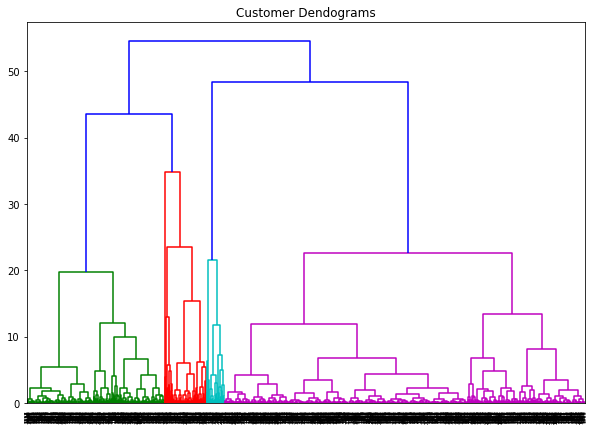

In [ ]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(X_data, method='ward'))

train time: 0.20s


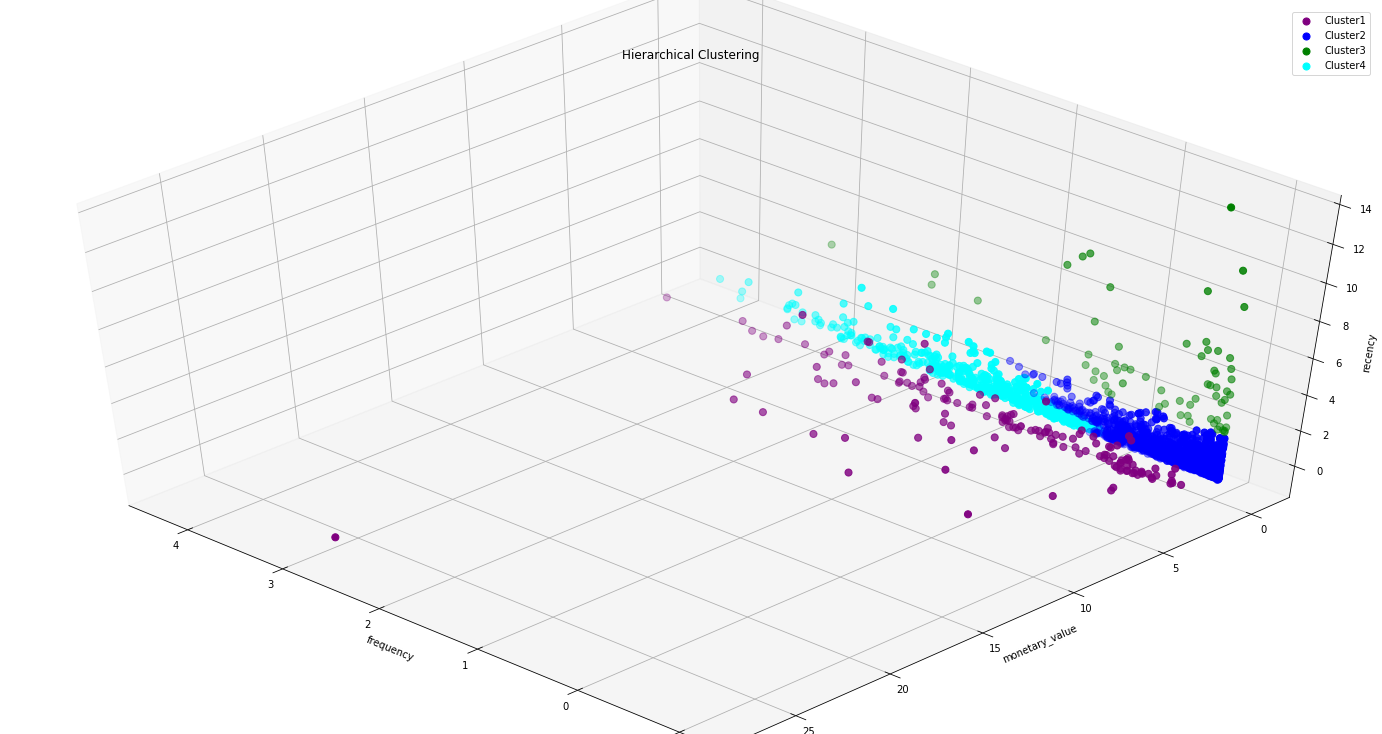

In [ ]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
t0 = time.time()
hr_cl = cluster.fit_predict(X_data)
t_batch = time.time() - t0
print('train time: %.2fs' % t_batch)

fig = plt.figure( figsize=(20, 10))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(X_data[hr_cl==0,0],X_data[hr_cl==0,1],X_data[hr_cl==0,2],s=50, c='purple',label='Cluster1')
ax.scatter(X_data[hr_cl==1,0],X_data[hr_cl==1,1],X_data[hr_cl==1,2],s=50, c='blue',label='Cluster2')
ax.scatter(X_data[hr_cl==2,0],X_data[hr_cl==2,1],X_data[hr_cl==2,2],s=50, c='green',label='Cluster3')
ax.scatter(X_data[hr_cl==3,0],X_data[hr_cl==3,1],X_data[hr_cl==3,2],s=50, c='cyan',label='Cluster4')
ax.set_title('Hierarchical Clustering')
ax.set_xlabel('frequency')
ax.set_ylabel('monetary_value')
ax.set_zlabel('recency')
ax.dist = 9
plt.legend()
plt.show()

In [ ]:
data_RFM["Cluster"]=hr_cl
data_RFM=data_RFM.groupby(['Cluster']).agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary_value': ['mean','count'],
}).round(0)

data_RFM.head()

recency frequency monetary_value      
           mean      mean           mean count
Cluster                                       
0         213.0       2.0          101.0   157
1          57.0       1.0           97.0  1346
2          84.0       1.0          702.0    66
3         273.0       1.0           84.0   516

### 3- DBSCAN

train time: 0.09s


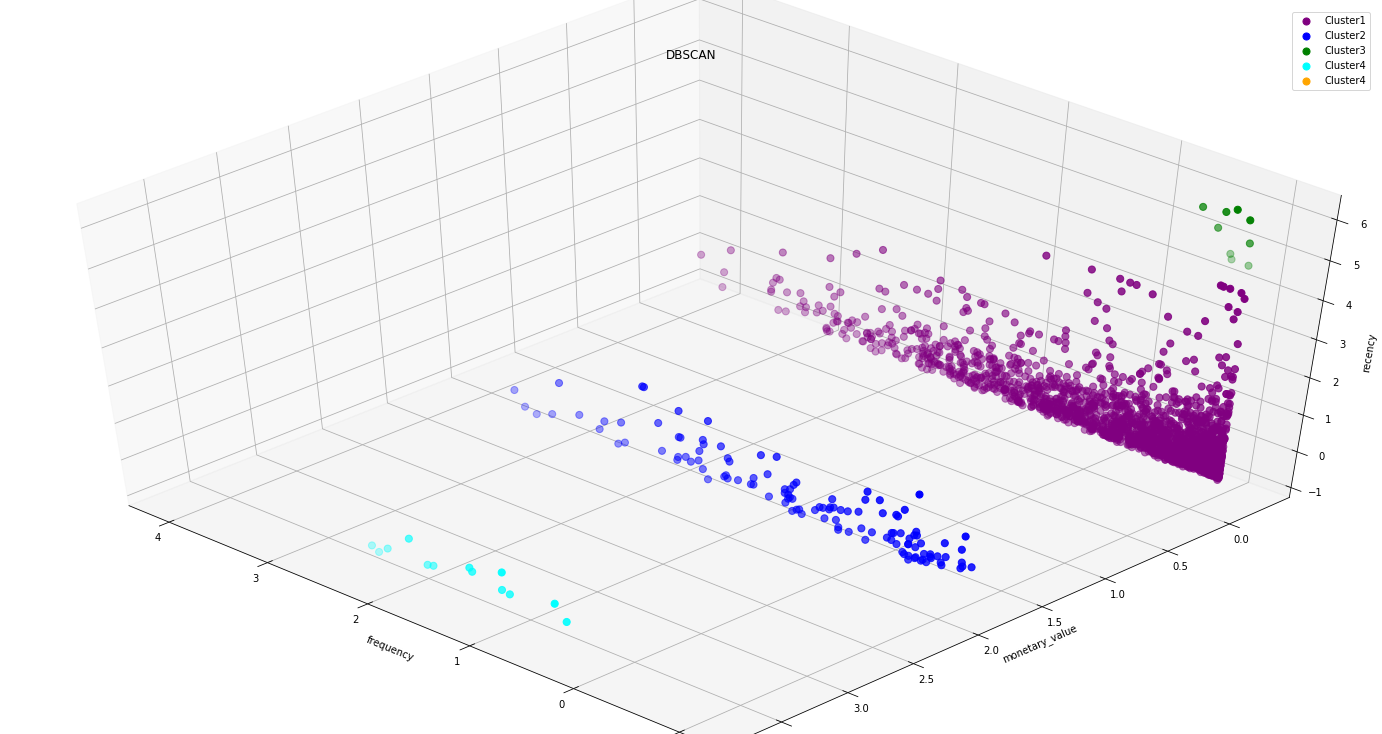

In [ ]:
dbscan = DBSCAN(eps=0.7, min_samples = 8)
t0 = time.time()
dbs = dbscan.fit_predict(X_data)
t_batch = time.time() - t0
print('train time: %.2fs' % t_batch)

fig = plt.figure( figsize=(20, 10))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(X_data[dbs==0,0],X_data[dbs==0,1],X_data[dbs==0,2],s=50, c='purple',label='Cluster1')
ax.scatter(X_data[dbs==1,0],X_data[dbs==1,1],X_data[dbs==1,2],s=50, c='blue',label='Cluster2')
ax.scatter(X_data[dbs==2,0],X_data[dbs==2,1],X_data[dbs==2,2],s=50, c='green',label='Cluster3')
ax.scatter(X_data[dbs==3,0],X_data[dbs==3,1],X_data[dbs==3,2],s=50, c='cyan',label='Cluster4')
ax.scatter(X_data[dbs==4,0],X_data[dbs==4,1],X_data[dbs==4,2],s=50, c='orange',label='Cluster4')

ax.set_title('DBSCAN')
ax.set_xlabel('frequency')
ax.set_ylabel('monetary_value')
ax.set_zlabel('recency')
ax.dist = 9
plt.legend()
plt.show()

In [ ]:
data_RFM["Cluster"]=dbs
data_RFM=data_RFM.groupby(['Cluster']).agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary_value': ['mean','count'],
}).round(0)

data_RFM.head()

recency frequency monetary_value      
           mean      mean           mean count
Cluster                                       
-1        227.0       3.0          543.0    40
 0        115.0       1.0          102.0  1902
 1        195.0       2.0           90.0   121
 2         23.0       1.0          888.0     9
 3        296.0       3.0           91.0    13

Après avoir tester plusieurs fois eps et min_samples pendant un certain temps, j'ai obtenu des clusters assez cohérents, comprenant toujours des points de bruit.

Donc ici,on a tester déffirents algorithme soit k-means, algorithme de l'agglomerative clustering et DBSCAN, on trouve que l'algorithme de DBSCAN ne nécessite pas que l'utilisateur définisse le nombre de clusters a priori et
est un peu plus lent que l'agglomerative clustering et k-means, mais reste à l'échelle pour des ensembles de données relativement importants et l'overfitting des données. Donc l'algorithme de K-means est similaire à l'algorithme de l'agglomerative clustering.

Comme notre but est de cherché une contrat de matenance à notre base de donnée de transaction des clients, on va faire une teste d'évaluation pour la stabilité des clusters au cours de temps avec K-Means.    

### Test et évaluation stabilité cluster

Test pour 1000 clients

In [ ]:
data_test_RFM = data_RFM.sample(1000)

In [ ]:
X= data_test_RFM
X.shape


(1000, 3)

In [ ]:
scaler = StandardScaler()
scaler.fit(X)
X_data = scaler.transform(X)
X_data.shape



(1000, 3)

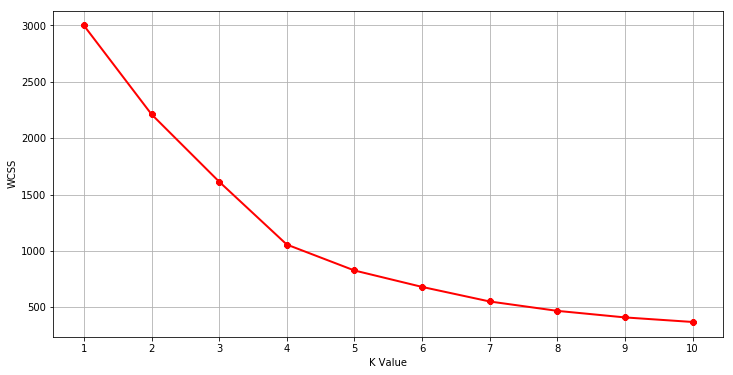

In [ ]:
wcss = []
for i in range(1,11):
    km_test=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km_test.fit(X_data)
    wcss.append(km_test.inertia_)
plt.figure(figsize=(12,6))
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

train time: 0.06s
inertia: 2492.149006


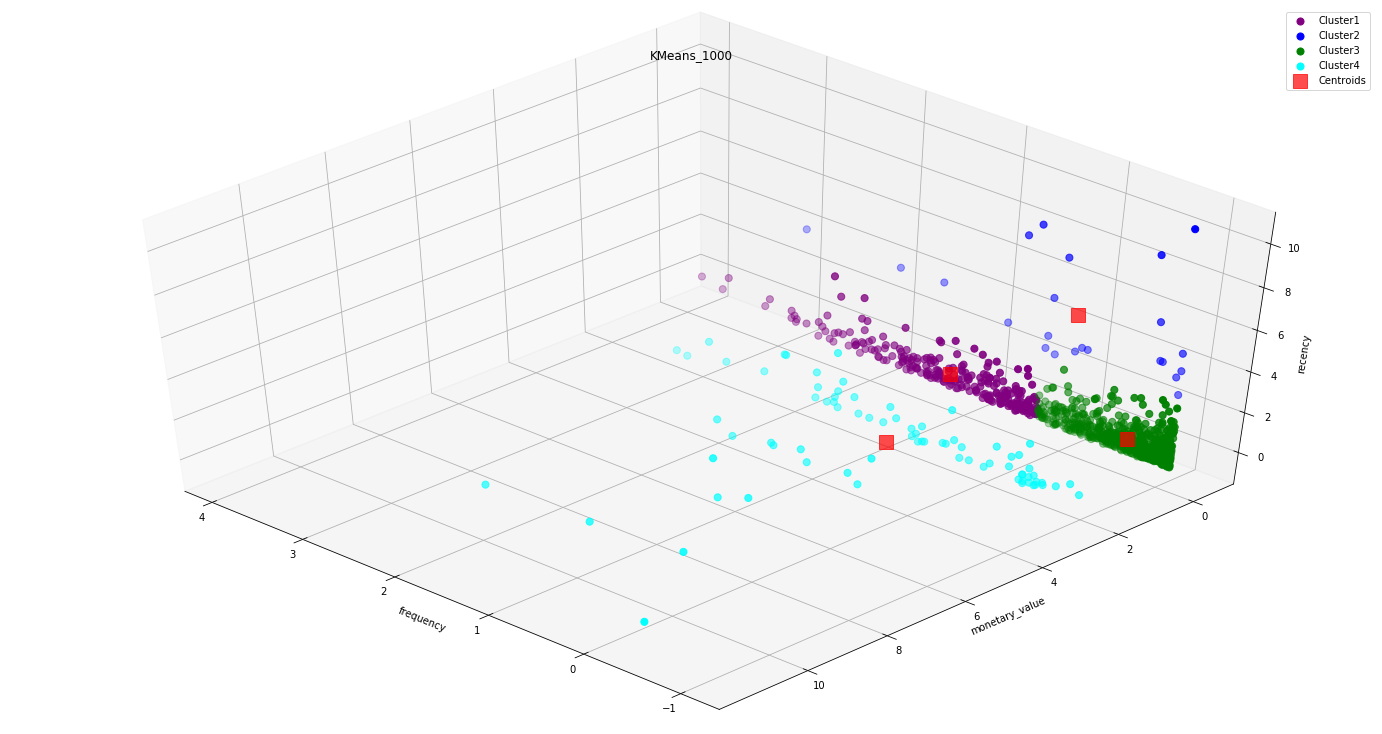

In [ ]:
k_means_test=KMeans(n_clusters=4,init='k-means++', max_iter=300, n_init=10, random_state=0)
t0 = time.time()
y_means_test = k_means_test.fit_predict(X_data)
t_batch = time.time() - t0
print('train time: %.2fs\ninertia: %f' % (t_batch, k_means.inertia_))

fig = plt.figure( figsize=(20, 10))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(X_data[y_means_test==0,0],X_data[y_means_test==0,1],X_data[y_means_test==0,2],s=50, c='purple',label='Cluster1')
ax.scatter(X_data[y_means_test==1,0],X_data[y_means_test==1,1],X_data[y_means_test==1,2],s=50, c='blue',label='Cluster2')
ax.scatter(X_data[y_means_test==2,0],X_data[y_means_test==2,1],X_data[y_means_test==2,2],s=50, c='green',label='Cluster3')
ax.scatter(X_data[y_means_test==3,0],X_data[y_means_test==3,1],X_data[y_means_test==3,2],s=50, c='cyan',label='Cluster4')
#ax.scatter(X_data[y_means==4,0],X_data[y_means==4,1],X_data[y_means==4,2],s=50, c='magenta',label='Cluster5')
#plt.scatter(X_data[y_means==5,0],X_data[y_means==5,1],s=50, c='orange',label='Cluster6')
ax.scatter(k_means_test.cluster_centers_[:,0], k_means_test.cluster_centers_[:,1], k_means_test.cluster_centers_[:,2],s=200,marker='s', c='red', alpha=0.7, label='Centroids')
ax.set_title('KMeans_1000')
ax.set_xlabel('frequency')
ax.set_ylabel('monetary_value')
ax.set_zlabel('recency')
ax.dist = 10
plt.legend()
plt.show()

In [ ]:
data_test_RFM["Cluster1000"]=y_means_test
data_test_RFM=data_test_RFM.groupby(['Cluster1000']).agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary_value': ['mean','count'],
}).round(0)

data_test_RFM.head()

recency frequency monetary_value      
               mean      mean           mean count
Cluster1000                                       
0             281.0       1.0           96.0   256
1             131.0       1.0          805.0    23
2              56.0       1.0           99.0   644
3             210.0       2.0          113.0    77

Test avec 1100 clients

In [ ]:
data_test_RFM2 = data_RFM.sample(1100)

In [ ]:
X= data_test_RFM2
X.shape

(1100, 3)

In [ ]:

scaler = StandardScaler()
scaler.fit(X)
X_data = scaler.transform(X)
X_data.shape



(1100, 3)

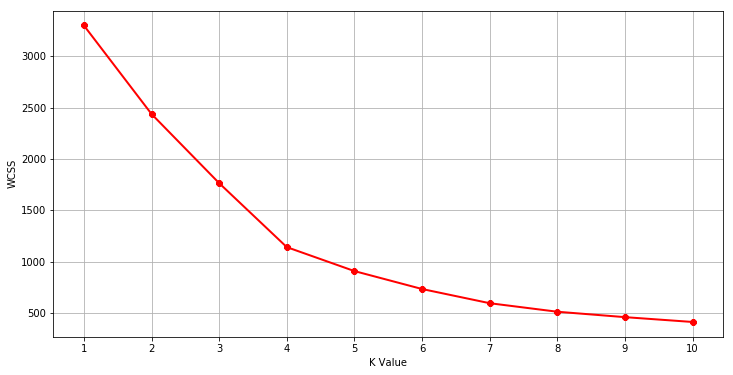

In [ ]:
wcss = []
for i in range(1,11):
    km_test2=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km_test2.fit(X_data)
    wcss.append(km_test2.inertia_)
plt.figure(figsize=(12,6))
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

train time: 0.08s
inertia: 2492.149006


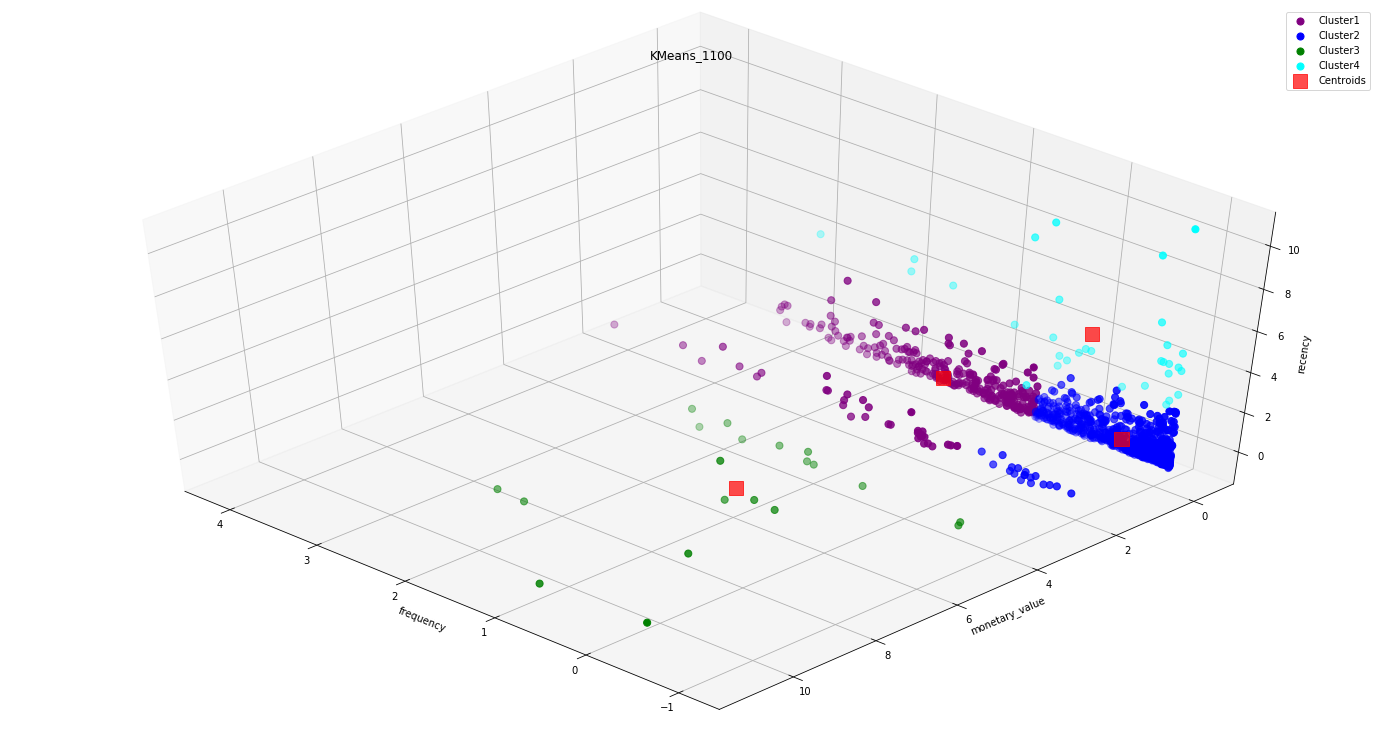

In [ ]:
k_means_test2=KMeans(n_clusters=4,init='k-means++', max_iter=300, n_init=10, random_state=0)
t0 = time.time()
y_means_test2 = k_means_test2.fit_predict(X_data)
t_batch = time.time() - t0
print('train time: %.2fs\ninertia: %f' % (t_batch, k_means.inertia_))

fig = plt.figure( figsize=(20, 10))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(X_data[y_means_test2==0,0],X_data[y_means_test2==0,1],X_data[y_means_test2==0,2],s=50, c='purple',label='Cluster1')
ax.scatter(X_data[y_means_test2==1,0],X_data[y_means_test2==1,1],X_data[y_means_test2==1,2],s=50, c='blue',label='Cluster2')
ax.scatter(X_data[y_means_test2==2,0],X_data[y_means_test2==2,1],X_data[y_means_test2==2,2],s=50, c='green',label='Cluster3')
ax.scatter(X_data[y_means_test2==3,0],X_data[y_means_test2==3,1],X_data[y_means_test2==3,2],s=50, c='cyan',label='Cluster4')
#ax.scatter(X_data[y_means==4,0],X_data[y_means==4,1],X_data[y_means==4,2],s=50, c='magenta',label='Cluster5')
#plt.scatter(X_data[y_means==5,0],X_data[y_means==5,1],s=50, c='orange',label='Cluster6')
ax.scatter(k_means_test2.cluster_centers_[:,0], k_means_test2.cluster_centers_[:,1], k_means_test2.cluster_centers_[:,2],s=200,marker='s', c='red', alpha=0.7, label='Centroids')
ax.set_title('KMeans_1100')
ax.set_xlabel('frequency')
ax.set_ylabel('monetary_value')
ax.set_zlabel('recency')
ax.dist = 10
plt.legend()
plt.show()

In [ ]:
data_test_RFM2["Cluster1100"]=y_means_test2
data_test_RFM2=data_test_RFM2.groupby(['Cluster1100']).agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary_value': ['mean','count'],
}).round(0)

data_test_RFM2.head()

recency frequency monetary_value      
               mean      mean           mean count
Cluster1100                                       
0             289.0       1.0          100.0   301
1              62.0       1.0           97.0   747
2             245.0       4.0          116.0    20
3             114.0       1.0          728.0    32

Test avec 1300

In [ ]:
data_test_RFM13 = data_RFM.sample(1300)
X= data_test_RFM13
X.shape


(1300, 3)

In [ ]:

scaler = StandardScaler()
scaler.fit(X)
X_data = scaler.transform(X)
X_data.shape


(1300, 3)

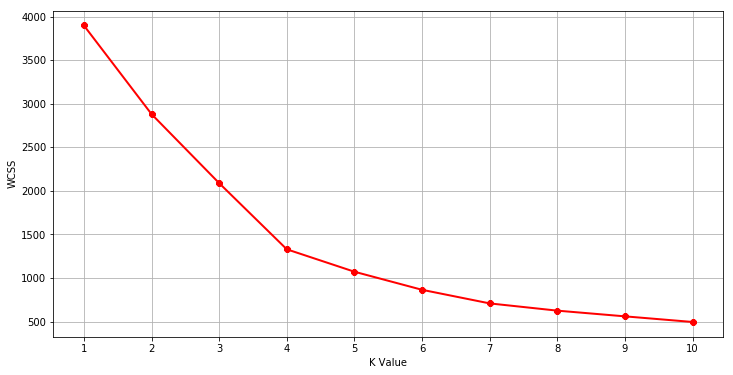

In [ ]:
wcss = []
for i in range(1,11):
    km_test13=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km_test13.fit(X_data)
    wcss.append(km_test13.inertia_)
plt.figure(figsize=(12,6))
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

train time: 0.07s
inertia: 2492.149006


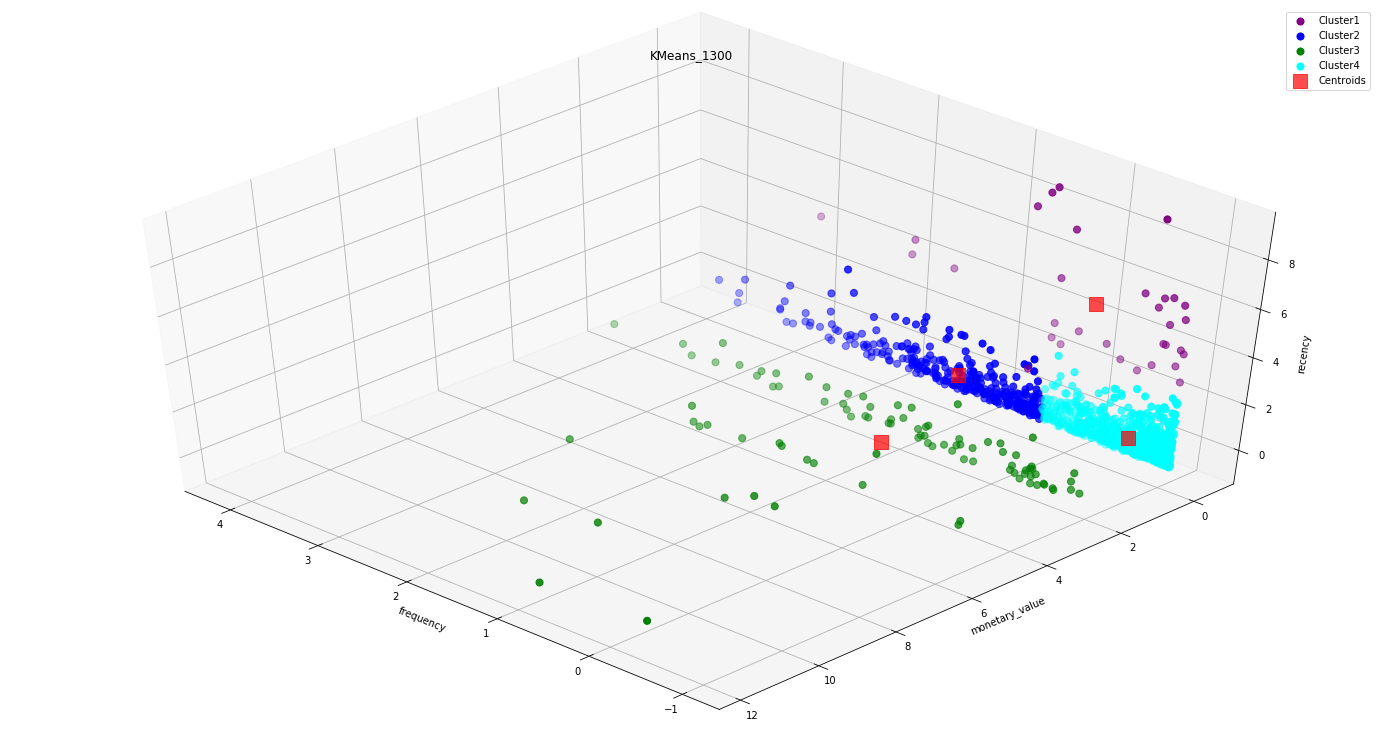

In [ ]:
k_means_test13=KMeans(n_clusters=4,init='k-means++', max_iter=300, n_init=10, random_state=0)
t0 = time.time()
y_means_test13 = k_means_test13.fit_predict(X_data)
t_batch = time.time() - t0
print('train time: %.2fs\ninertia: %f' % (t_batch, k_means.inertia_))

fig = plt.figure( figsize=(20, 10))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(X_data[y_means_test13==0,0],X_data[y_means_test13==0,1],X_data[y_means_test13==0,2],s=50, c='purple',label='Cluster1')
ax.scatter(X_data[y_means_test13==1,0],X_data[y_means_test13==1,1],X_data[y_means_test13==1,2],s=50, c='blue',label='Cluster2')
ax.scatter(X_data[y_means_test13==2,0],X_data[y_means_test13==2,1],X_data[y_means_test13==2,2],s=50, c='green',label='Cluster3')
ax.scatter(X_data[y_means_test13==3,0],X_data[y_means_test13==3,1],X_data[y_means_test13==3,2],s=50, c='cyan',label='Cluster4')
#ax.scatter(X_data[y_means==4,0],X_data[y_means==4,1],X_data[y_means==4,2],s=50, c='magenta',label='Cluster5')
#plt.scatter(X_data[y_means==5,0],X_data[y_means==5,1],s=50, c='orange',label='Cluster6')
ax.scatter(k_means_test13.cluster_centers_[:,0], k_means_test13.cluster_centers_[:,1], k_means_test13.cluster_centers_[:,2],s=200,marker='s', c='red', alpha=0.7, label='Centroids')
ax.set_title('KMeans_1300')
ax.set_xlabel('frequency')
ax.set_ylabel('monetary_value')
ax.set_zlabel('recency')
ax.dist = 10
plt.legend()
plt.show()

In [ ]:
data_test_RFM13["Cluster1300"]=y_means_test13
data_test_RFM13=data_test_RFM13.groupby(['Cluster1300']).agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary_value': ['mean','count'],
}).round(0)

data_test_RFM13.head()

recency frequency monetary_value      
               mean      mean           mean count
Cluster1300                                       
0             113.0       1.0          795.0    32
1             281.0       1.0           94.0   318
2             222.0       2.0           95.0    92
3              57.0       1.0           96.0   858

Test avec 1500

In [ ]:
data_test_RFM15 = data_RFM.sample(1500)
X= data_test_RFM15
X.shape


(1500, 3)

In [ ]:

scaler = StandardScaler()
scaler.fit(X)
X_data = scaler.transform(X)
X_data.shape

(1500, 3)

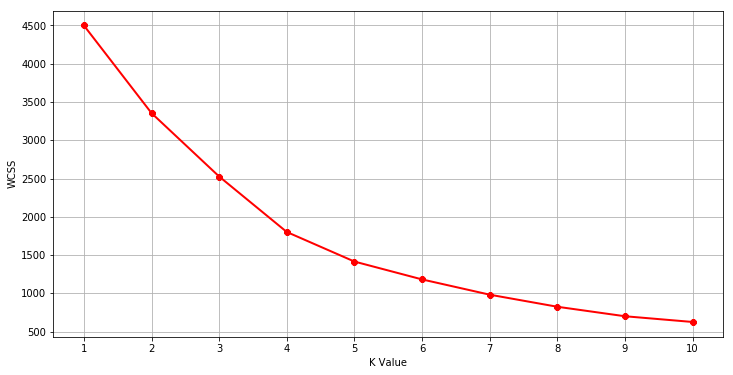

In [ ]:
wcss = []
for i in range(1,11):
    km_test15=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km_test15.fit(X_data)
    wcss.append(km_test15.inertia_)
plt.figure(figsize=(12,6))
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

train time: 0.08s
inertia: 2492.149006


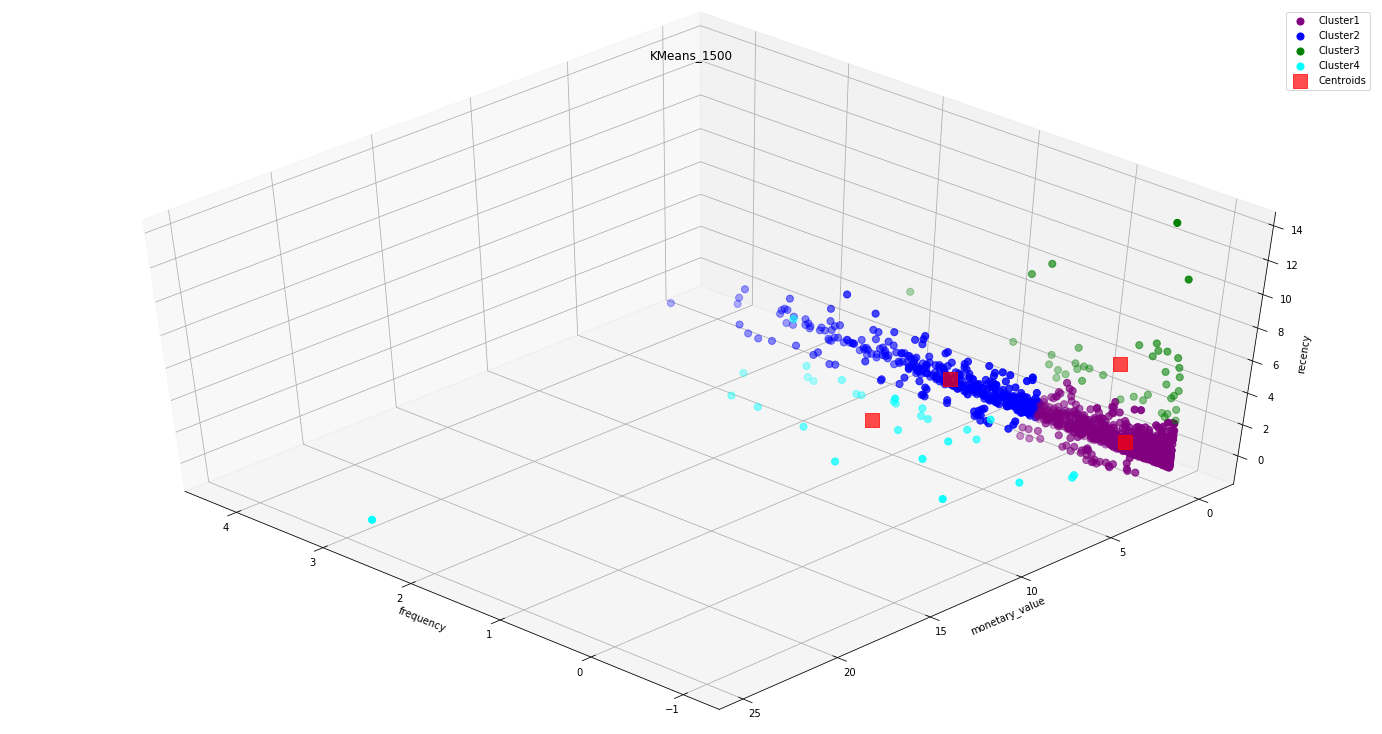

In [ ]:
k_means_test15=KMeans(n_clusters=4,init='k-means++', max_iter=300, n_init=10, random_state=0)
t0 = time.time()
y_means_test15 = k_means_test15.fit_predict(X_data)
t_batch = time.time() - t0
print('train time: %.2fs\ninertia: %f' % (t_batch, k_means.inertia_))

fig = plt.figure( figsize=(20, 10))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(X_data[y_means_test15==0,0],X_data[y_means_test15==0,1],X_data[y_means_test15==0,2],s=50, c='purple',label='Cluster1')
ax.scatter(X_data[y_means_test15==1,0],X_data[y_means_test15==1,1],X_data[y_means_test15==1,2],s=50, c='blue',label='Cluster2')
ax.scatter(X_data[y_means_test15==2,0],X_data[y_means_test15==2,1],X_data[y_means_test15==2,2],s=50, c='green',label='Cluster3')
ax.scatter(X_data[y_means_test15==3,0],X_data[y_means_test15==3,1],X_data[y_means_test15==3,2],s=50, c='cyan',label='Cluster4')
#ax.scatter(X_data[y_means==4,0],X_data[y_means==4,1],X_data[y_means==4,2],s=50, c='magenta',label='Cluster5')
#plt.scatter(X_data[y_means==5,0],X_data[y_means==5,1],s=50, c='orange',label='Cluster6')
ax.scatter(k_means_test15.cluster_centers_[:,0], k_means_test15.cluster_centers_[:,1], k_means_test15.cluster_centers_[:,2],s=200,marker='s', c='red', alpha=0.7, label='Centroids')
ax.set_title('KMeans_1500')
ax.set_xlabel('frequency')
ax.set_ylabel('monetary_value')
ax.set_zlabel('recency')
ax.dist = 10
plt.legend()
plt.show()

In [ ]:
data_test_RFM15["Cluster1500"]=y_means_test15
data_test_RFM15=data_test_RFM15.groupby(['Cluster1500']).agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary_value': ['mean','count'],
}).round(0)

data_test_RFM15.head()

recency frequency monetary_value      
               mean      mean           mean count
Cluster1500                                       
0              59.0       1.0           93.0  1041
1             287.0       1.0           97.0   390
2              77.0       1.0          734.0    40
3             268.0       4.0          121.0    29

Test avec 1750

In [ ]:
data_test_RFM175 = data_RFM.sample(1750)
X= data_test_RFM175
X.shape


(1750, 3)

In [ ]:
scaler = StandardScaler()
scaler.fit(X)
X_data = scaler.transform(X)
X_data.shape

(1750, 3)

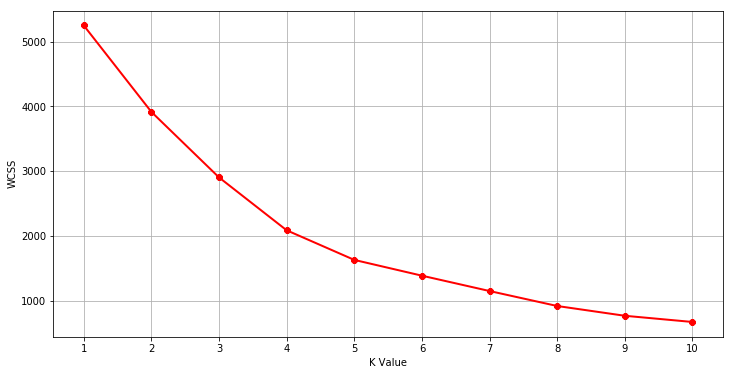

In [ ]:
wcss = []
for i in range(1,11):
    km_test175=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km_test175.fit(X_data)
    wcss.append(km_test175.inertia_)
plt.figure(figsize=(12,6))
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

train time: 0.07s
inertia: 2492.149006


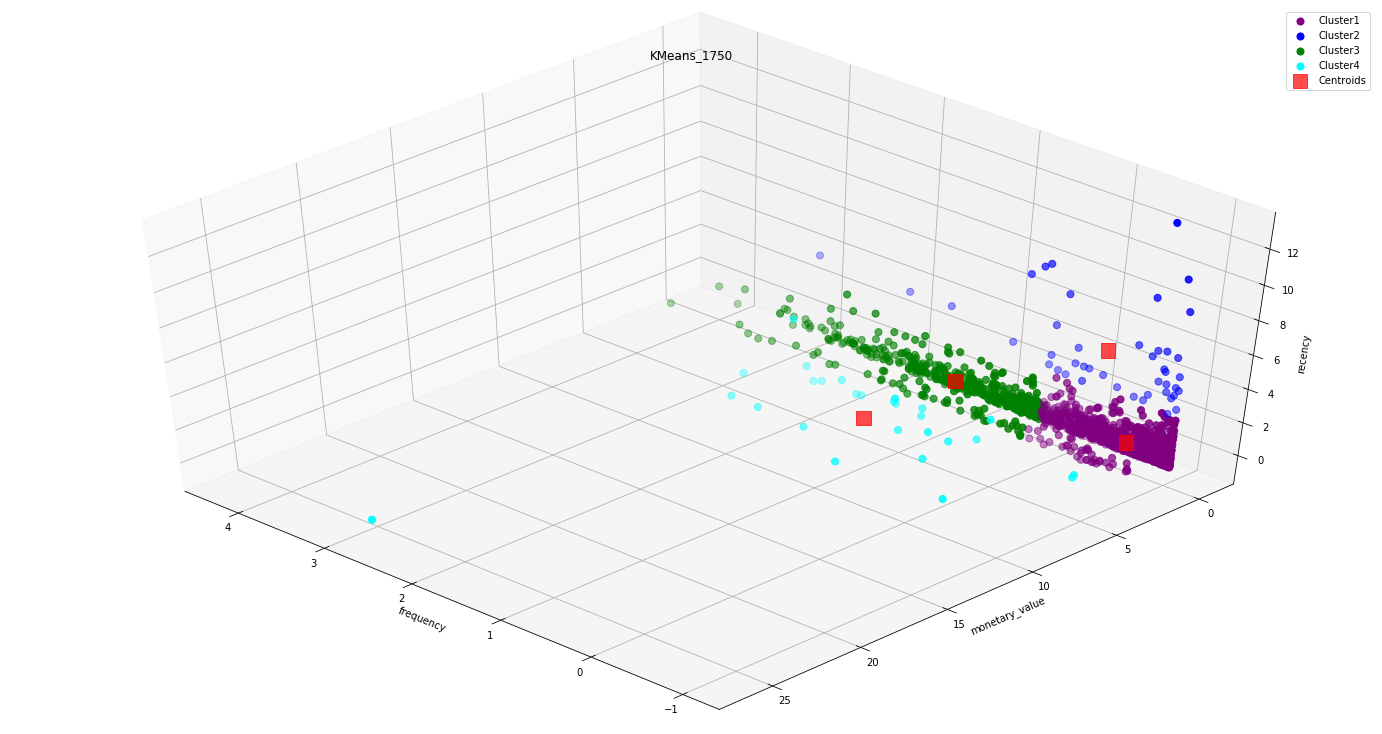

In [ ]:
k_means_test175=KMeans(n_clusters=4,init='k-means++', max_iter=300, n_init=10, random_state=0)
t0 = time.time()
y_means_test175 = k_means_test175.fit_predict(X_data)
t_batch = time.time() - t0
print('train time: %.2fs\ninertia: %f' % (t_batch, k_means.inertia_))

fig = plt.figure( figsize=(20, 10))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(X_data[y_means_test175==0,0],X_data[y_means_test175==0,1],X_data[y_means_test175==0,2],s=50, c='purple',label='Cluster1')
ax.scatter(X_data[y_means_test175==1,0],X_data[y_means_test175==1,1],X_data[y_means_test175==1,2],s=50, c='blue',label='Cluster2')
ax.scatter(X_data[y_means_test175==2,0],X_data[y_means_test175==2,1],X_data[y_means_test175==2,2],s=50, c='green',label='Cluster3')
ax.scatter(X_data[y_means_test175==3,0],X_data[y_means_test175==3,1],X_data[y_means_test175==3,2],s=50, c='cyan',label='Cluster4')
#ax.scatter(X_data[y_means==4,0],X_data[y_means==4,1],X_data[y_means==4,2],s=50, c='magenta',label='Cluster5')
#plt.scatter(X_data[y_means==5,0],X_data[y_means==5,1],s=50, c='orange',label='Cluster6')
ax.scatter(k_means_test175.cluster_centers_[:,0], k_means_test175.cluster_centers_[:,1], k_means_test175.cluster_centers_[:,2],s=200,marker='s', c='red', alpha=0.7, label='Centroids')
ax.set_title('KMeans_1750')
ax.set_xlabel('frequency')
ax.set_ylabel('monetary_value')
ax.set_zlabel('recency')
ax.dist = 10
plt.legend()
plt.show()

In [ ]:
data_test_RFM175["Cluster1750"]=y_means_test175
data_test_RFM175=data_test_RFM175.groupby(['Cluster1750']).agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary_value': ['mean','count'],
}).round(0)

data_test_RFM175.head()

recency frequency monetary_value      
               mean      mean           mean count
Cluster1750                                       
0              57.0       1.0           97.0  1200
1              93.0       1.0          808.0    44
2             280.0       1.0           94.0   479
3             276.0       4.0          128.0    27

Enfin, on peut dire que notre devis maintenance est respecté par les nouveaux clients et qui basée sur une analyse de la stabilité des segments au cours du temps.

### Importance relative des attributs de segment

In [ ]:
data_RFM["Cluster"]=y_means
data_RFM=data_RFM.groupby(['Cluster']).agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary_value': 'mean',
}).round(0)

data_RFM.head()

,recency,frequency,monetary_value
Cluster,,,
0,95.0,1.0,806.0
1,58.0,1.0,96.0
2,283.0,1.0,97.0
3,270.0,4.0,121.0


In [ ]:
cluster_avg = data_RFM.groupby(['Cluster']).mean()
cluster_avg

,recency,frequency,monetary_value
Cluster,,,
0,95.0,1.0,806.0
1,58.0,1.0,96.0
2,283.0,1.0,97.0
3,270.0,4.0,121.0


In [ ]:
cust_avg = data_RFM.mean()
cust_avg

recency           176.50
frequency           1.75
monetary_value    280.00
dtype: float64

Analyser et tracer l'importance relative

In [ ]:
relative_imp = cluster_avg / cust_avg - 1

In [ ]:
relative_imp.round(2)

,recency,frequency,monetary_value
Cluster,,,
0,-0.46,-0.43,1.88
1,-0.67,-0.43,-0.66
2,0.60,-0.43,-0.65
3,0.53,1.29,-0.57


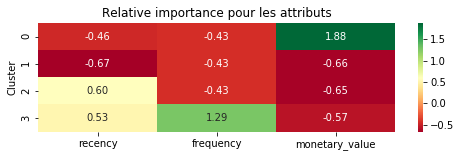

In [ ]:
plt.figure(figsize=(8, 2))
plt.title('Relative importance pour les attributs')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()


Plus un ratio est éloigné de 0, plus cet attribut est important pour un segment par rapport à les clients totale